# Simulate some data to test the method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel

from stardate.lhf import gyro_model_rossby, gyro_model, sigma, calc_rossby_number

bands = ["B", "V", "J", "H", "K", "BP", "RP", "G"]
mist = MIST_Isochrone(bands)
mist.initialize()

Draw randomly from mass, age, metallicity, distance and extinction distributions. Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [2]:
def generate_df(N=1000, with_noise=False):
    """
    Simulate stellar properties from an distribution of EEPss, ages, 
    metallicities, distances and extinctions.
    """

    np.random.seed(42)
    eep = np.random.uniform(195, 480, size=N)
    age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
    feh = np.random.uniform(-.2, .2, size=N)
    mass = mist.interp_value([eep, age, feh], ["mass"])
    d_kpc = np.random.uniform(.01, 1, size=N)
    d_pc = d_kpc*1e3
    av = np.random.uniform(0, .1, size=N)

    # Save as a pandas data frame
    df = pd.DataFrame(dict({"eep": eep, "age": age, "feh": feh, "d_kpc": d_kpc, "Av": av}))
    
    logg, teff, feh_interp, B, V, J, H, K, BP, RP, G, logL = [np.zeros(N) for i in range(12)]
    print("Calculating stellar parameters...")
    for i in trange(N):
        teff[i], logg[i], feh_interp[i], bands = mist.interp_mag(
            [eep[i], age[i], feh[i], d_pc[i], av[i]], 
            ["B", "V", "J", "H", "K", "BP", "RP", "G"])
        B[i], V[i], J[i], H[i], K[i], BP[i], RP[i], G[i] = bands
        logL[i] = mist.interp_value([eep[i], age[i], feh[i]], ["logL"])[0]
    
    df["B_err"] = np.ones_like(N)*.05
    df["V_err"] = np.ones_like(N)*.05
    df["J_err"] = np.ones_like(N)*.05
    df["H_err"] = np.ones_like(N)*.05
    df["K_err"] = np.ones_like(N)*.05
    df["BP_err"] = np.ones_like(N)*.001
    df["RP_err"] = np.ones_like(N)*.001
    df["G_err"] = np.ones_like(N)*.001
    df["teff_err"] = np.ones_like(N)*25
    df["logg_err"] = np.ones_like(N)*.01
    df["feh_err"] = np.ones_like(N)*.01
        
    if with_noise:
        np.random.seed(42)
        B += np.random.randn(N)*df["B_err"]
        V += np.random.randn(N)*df["V_err"]
        J += np.random.randn(N)*df["J_err"] 
        K += np.random.randn(N)*df["H_err"]
        H += np.random.randn(N)*df["K_err"]
        BP += np.random.randn(N)*df["BP_err"]
        RP += np.random.randn(N)*df["RP_err"]
        G += np.random.randn(N)*df["G_err"]
        teff += np.random.randn(N)*df["teff_err"]
        logg += np.random.randn(N)*df["logg_err"]
        feh += np.random.randn(N)*df["feh_err"]
        
    df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"] = B - V, B, V, J, H, K
    df["BP"], df["RP"], df["G"] = BP, RP, G
    df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
    df["mass"] = mist.mass(df.eep, df.age, df.feh)
    
    # Calculate periods. NaNs will appear for stars with B-V < 0.45
    np.random.seed(42)
    log_prot, prot_err, log_prot_praesepe, prot_err_praesepe = [np.empty(N) for i in range(4)]
    period_uncertainty = .01
    print("Calculating rotation periods...")
    for i in trange(N):
        log_prot[i] = gyro_model_rossby(df.age.values[i], df.BV.values[i], 
                                        df.mass.values[i], rossby=True, Ro_cutoff=2, model="angus15")
        log_prot[i] = gyro_model_rossby(df.age.values[i], df.BP.values[i] - df.RP.values[i], 
                                        df.mass.values[i], rossby=True, Ro_cutoff=2, model="praesepe")
        prot_err[i] = (10**log_prot[i])*period_uncertainty
        prot_err_praesepe[i] = (10**log_prot_praesepe[i])*period_uncertainty
    
    # Add variance to these.
    sig = sigma(df.BV.values, df.eep.values)
    scatter = np.random.randn(len(log_prot))*sig
    log_prot_scatter = log_prot + scatter
    
    # Add variance to these.
    sig_praesepe = sigma(df.BP.values - df.RP.values, df.eep.values, model="praesepe")
    scatter = np.random.randn(len(log_prot_praesepe))*sig_praesepe
    log_prot_scatter_praesepe = log_prot_praesepe + scatter
    
    noise = 0
    if with_noise:
        noise = np.random.randn(N)*.1

    df["prot"] = 10**log_prot_scatter + noise
    df["prot_praesepe"] = 10**log_prot_scatter_praesepe + noise
    df["prot_clean"] = 10**log_prot
    df["prot_clean_prasepe"] = 10**log_prot_praesepe
    df["prot_err"] = prot_err
    df["prot_err_praesepe"] = prot_err_praesepe
    df["Ro"] = calc_rossby_number(df.prot, df.mass)
    df["Ro_praesepe"] = calc_rossby_number(df.prot_praesepe, df.mass)

    # Cut unphysical masses
    finite_mask = np.isfinite(df.mass.values)
    finite_df = df.iloc[finite_mask]
    print(len(df.mass.values), "stars originally, ", len(df.mass.values[finite_mask]), "after cuts")
    
    finite_df["ID"] = range(len(finite_df))

    return finite_df

In [3]:
df = generate_df(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating stellar parameters...
Calculating rotation periods...
9.477019116816836 9.920605437202669
9.477019116816836 9.819187989765922
9.892965813278295 9.588968247581747
9.892965813278295 9.518055294624663
10.089366986893925 9.760920082677783
10.089366986893925 9.67382378818056
10.016408004967223 9.890062048821015
10.016408004967223 9.776268206704676
10.056469405127391 nan


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in double_scalars



UnboundLocalError: local variable 'log_P' referenced before assignment

Plot the simulated data on an HR diagram.

Text(0, 0.5, '$\\log(g)$')

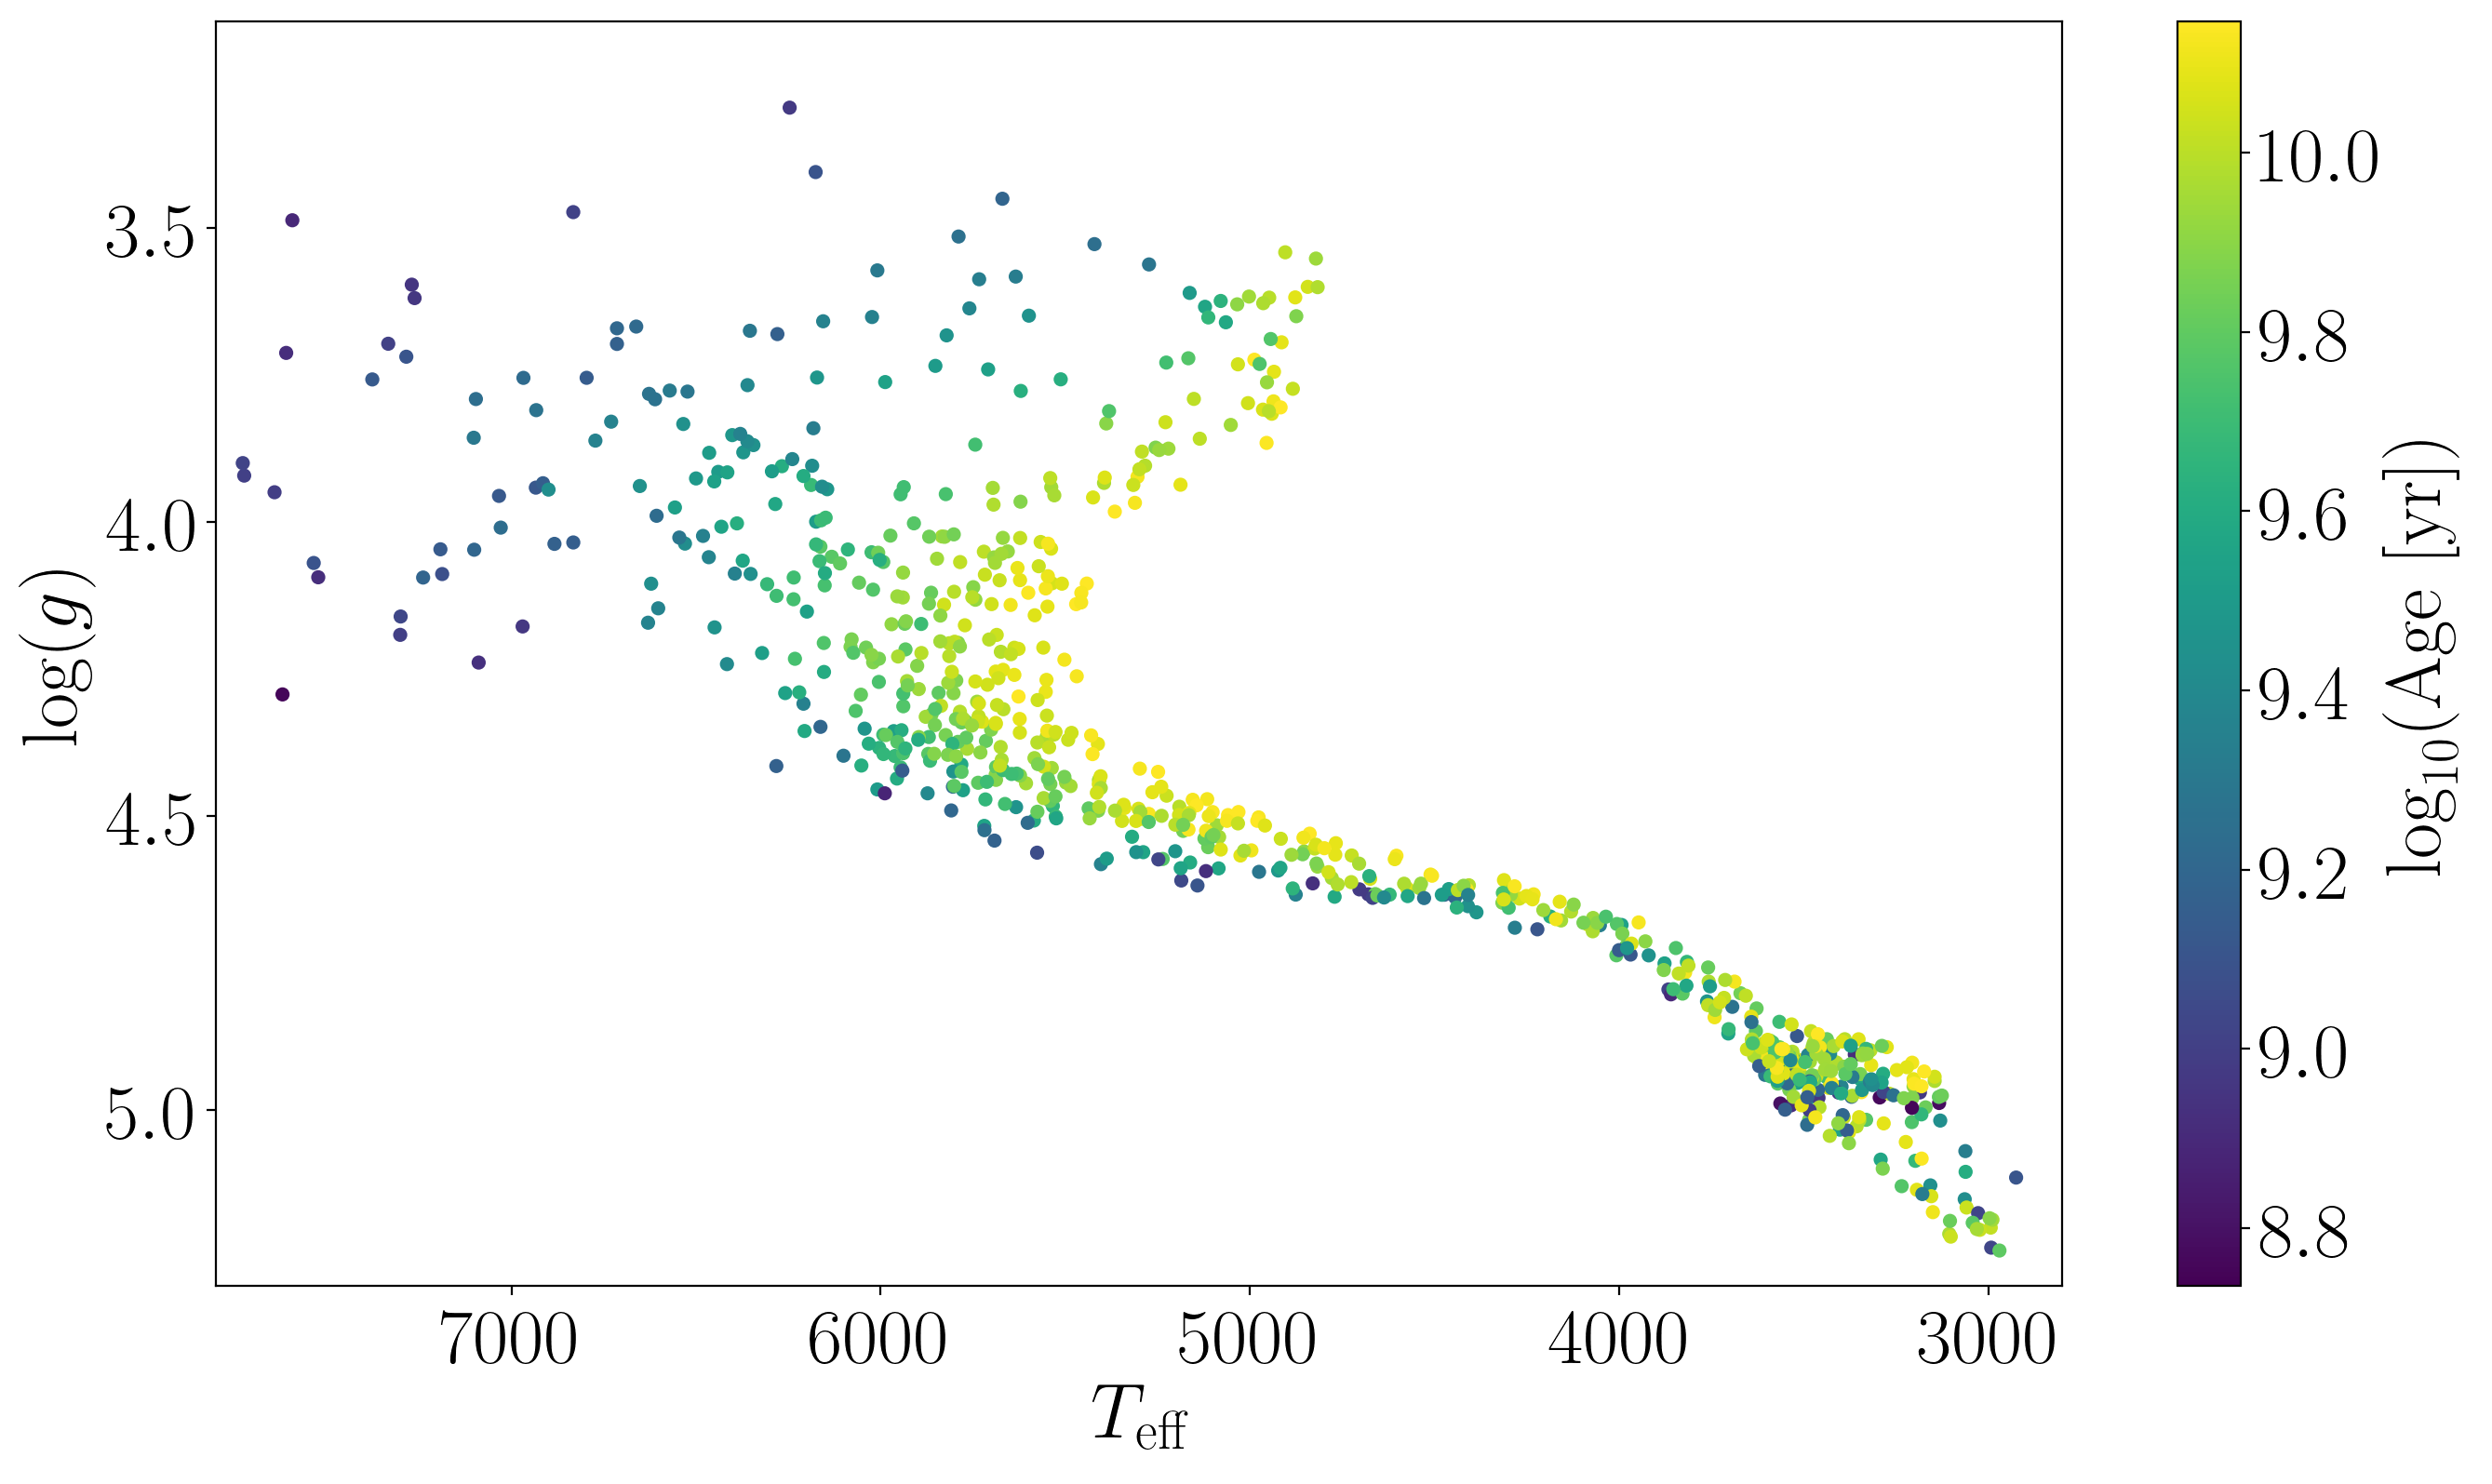

In [129]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Define functions for plotting gyrochrones. These won't include the Rossby number dependence.

In [122]:
def gyro_rot(log_age_yr, bv):
    age_myr = (10**(log_age_yr))*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    return age_myr**n * a * (bv - c)**b

def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

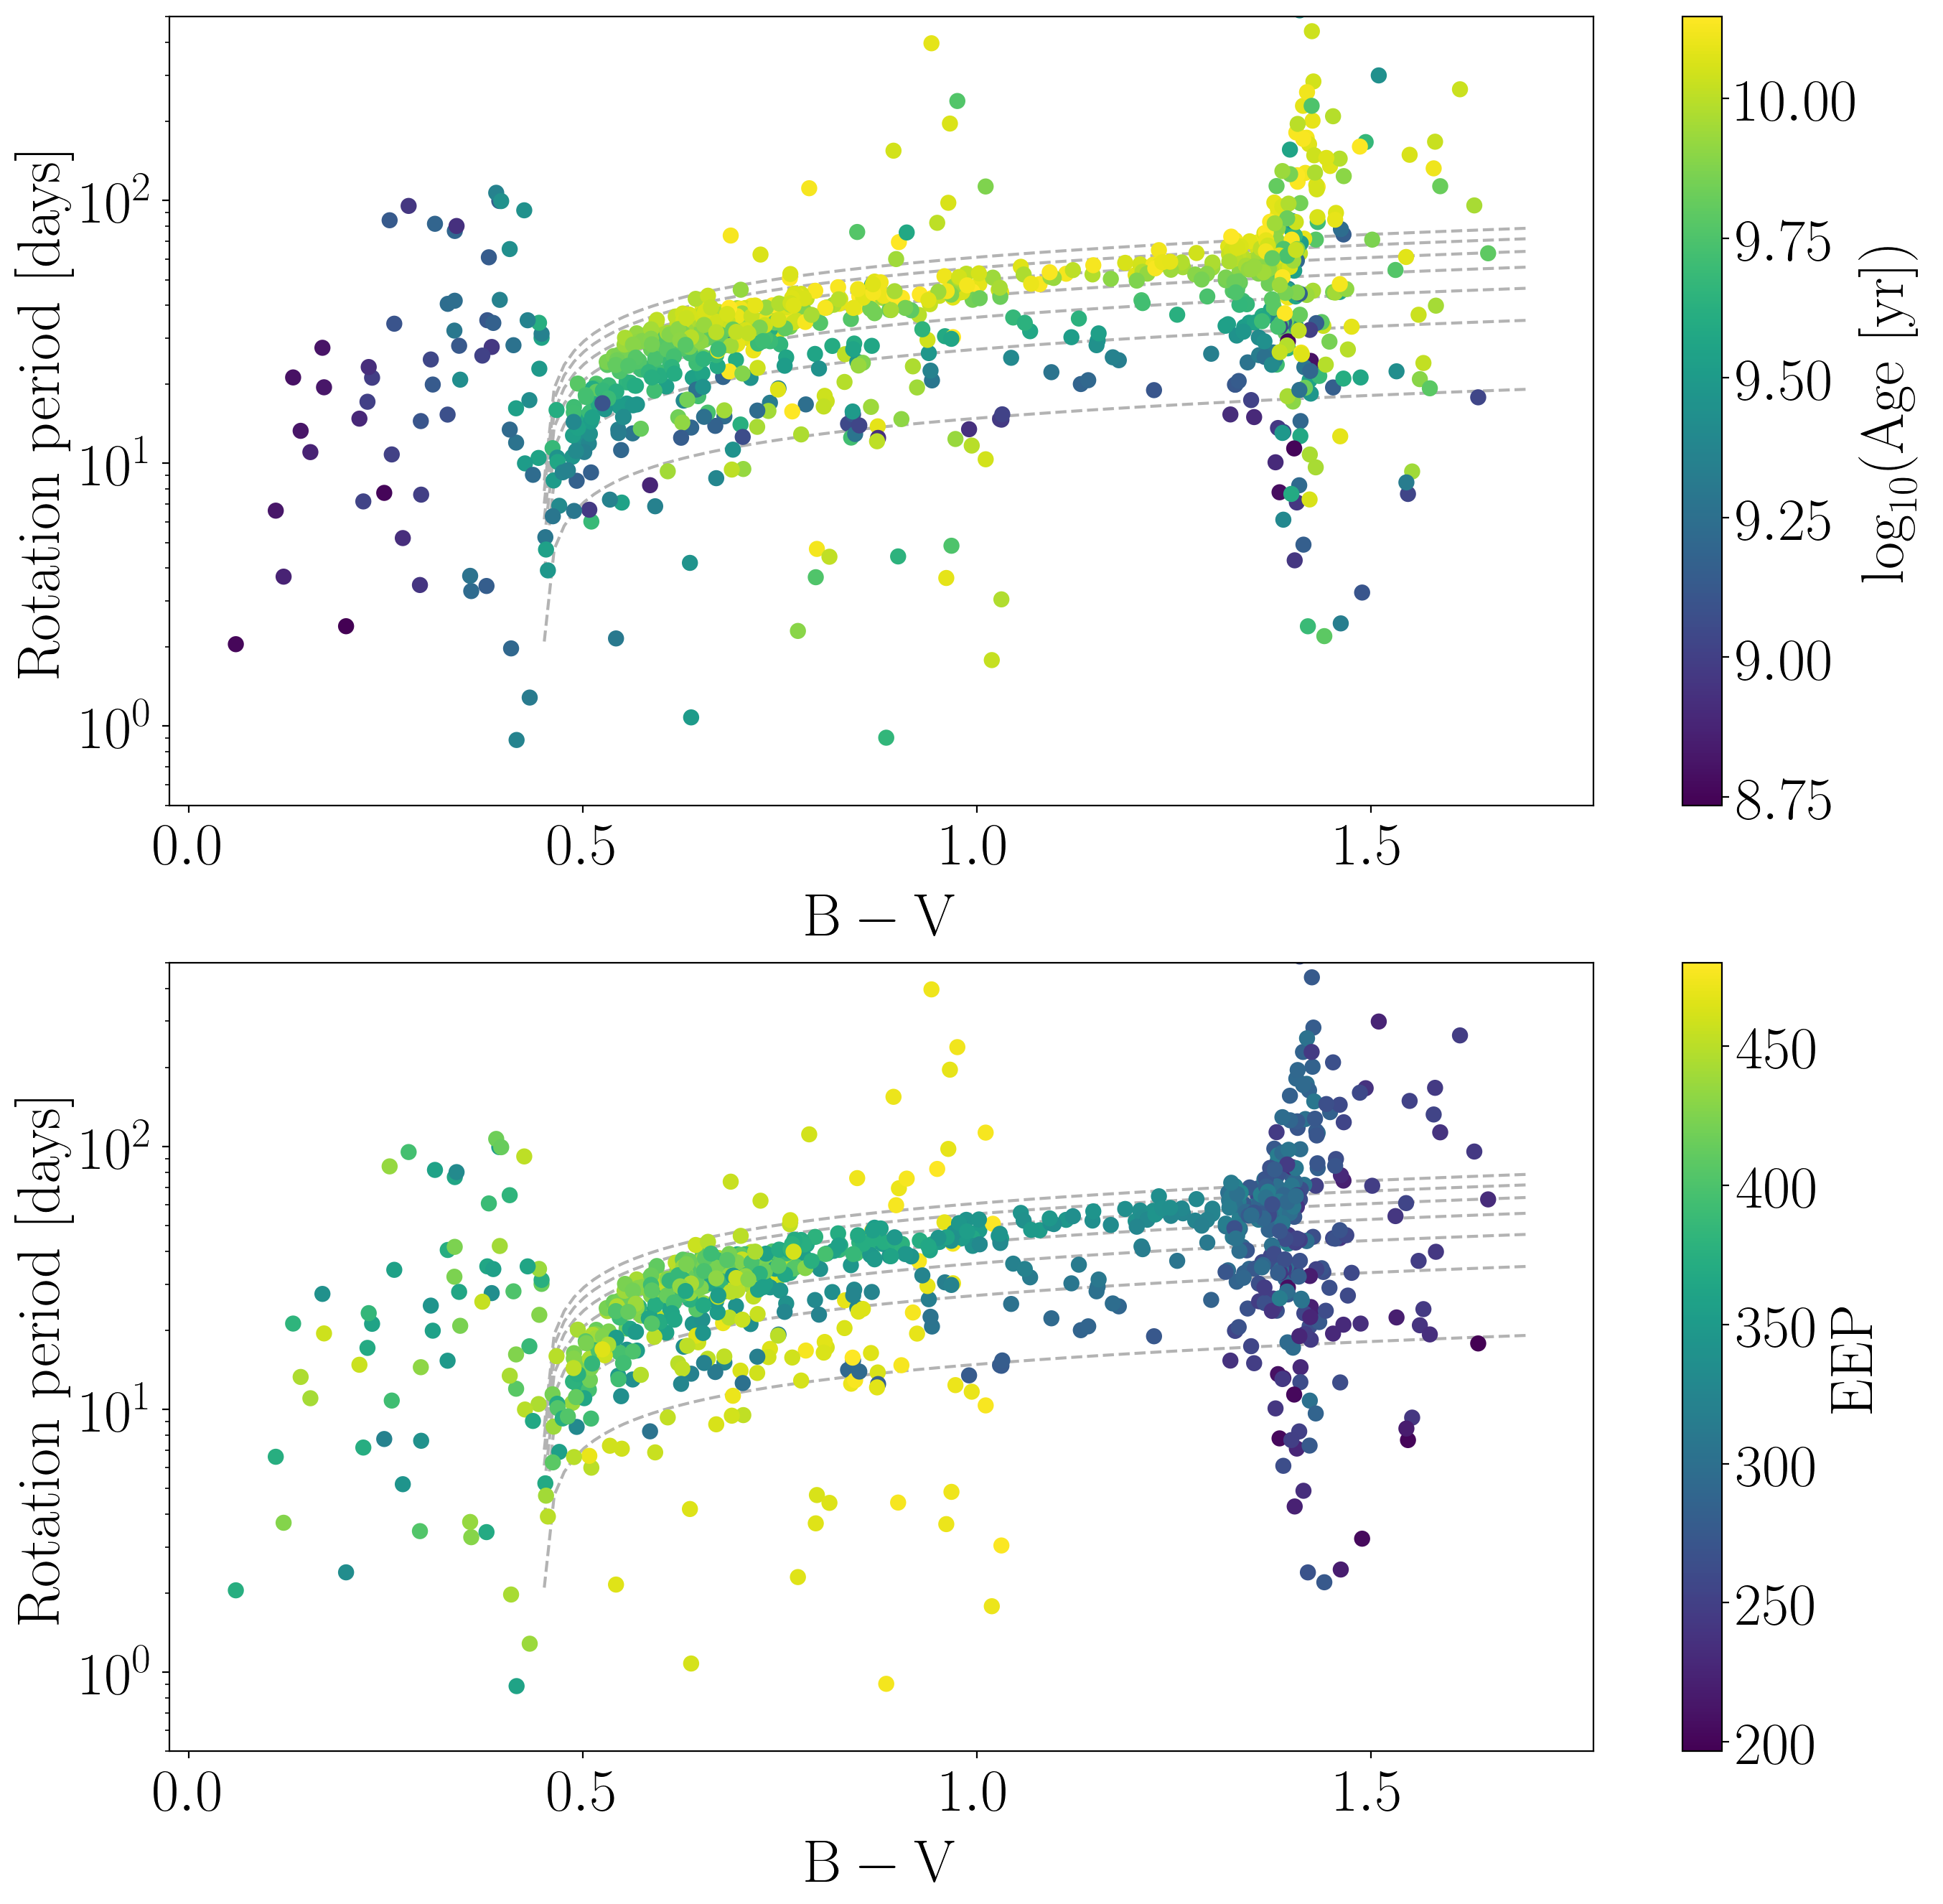

In [150]:
plt.figure(figsize=(16, 16), dpi=200)

plt.subplot(2, 1, 1)
# Plot models
xs = np.linspace(.451, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.age, s=50, zorder=1)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")
plt.ylim(.5, 500)

plt.subplot(2, 1, 2)
# Plot models
xs = np.linspace(.451, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.eep, s=50, zorder=1)
plt.colorbar(label="$\mathrm{EEP}$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")
plt.ylim(.5, 500)
plt.subplots_adjust(hspace=.2)
plt.savefig("../rotation_model.pdf")

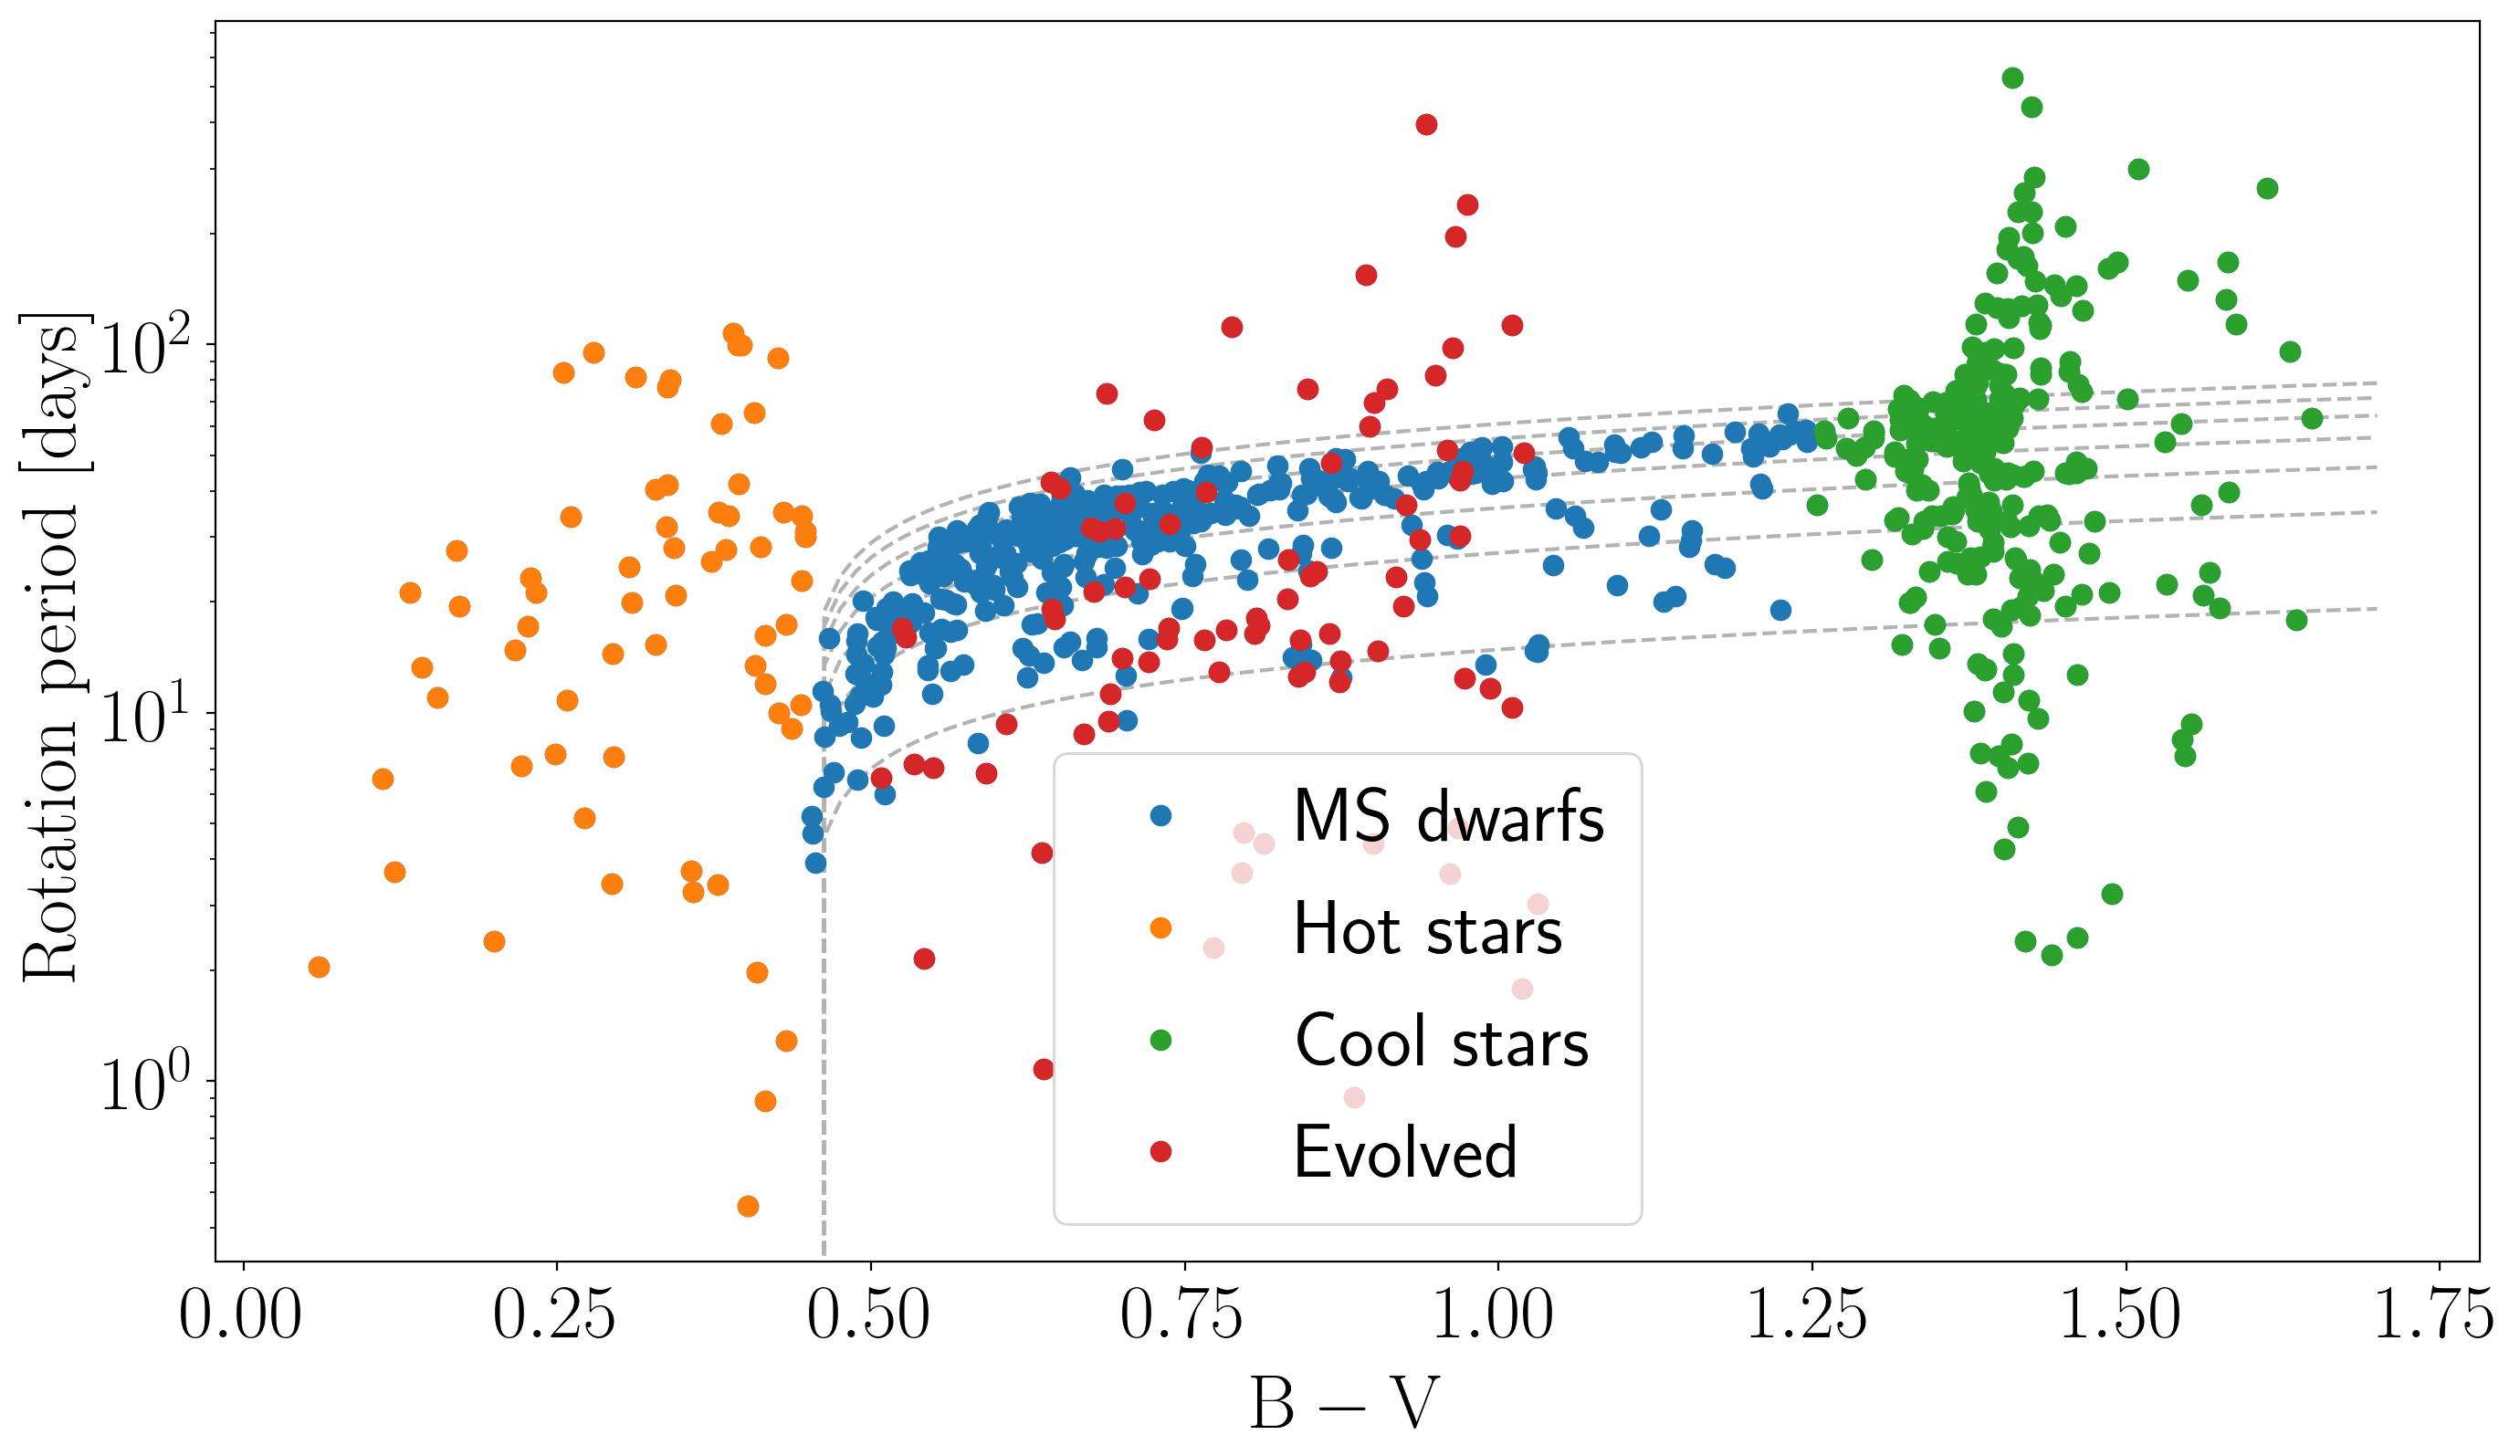

In [135]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.45, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

hot_mask = finite_df.BV < .45
cool_mask = 1.25 < finite_df.BV
evolved_mask = (.45 < finite_df.BV) * (454 < finite_df.eep)

plt.plot(finite_df.BV, finite_df.prot, ".", ms=15 , zorder=0, label="MS dwarfs")
plt.plot(finite_df.BV[hot_mask], finite_df.prot[hot_mask], ".", ms=15 , zorder=1, label="Hot stars")
plt.plot(finite_df.BV[cool_mask], finite_df.prot[cool_mask], ".", ms=15 , zorder=1, label="Cool stars")
plt.plot(finite_df.BV[evolved_mask], finite_df.prot[evolved_mask], ".", ms=15, zorder=1, label="Evolved")
plt.legend()
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")

Save simulated data file.

In [151]:
df.to_csv("data/simulated_data.csv")

Generate some noisy data too.

In [156]:
df_noise = generate_df(1000, with_noise=True)
df_noise.to_csv("data/simulated_data_noisy.csv")

100%|██████████| 1000/1000 [00:00<00:00, 35885.86it/s]

Calculating stellar parameters...
Calculating rotation periods...
1000 stars originally,  841 after cuts



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Now let's make a plot of the model.

In [47]:
large_df = generate_df(1000000)

  0%|          | 1506/1000000 [00:00<01:06, 15053.98it/s]

Calculating stellar parameters...


  1%|          | 8233/1000000 [00:00<00:23, 41415.67it/s]

Calculating rotation periods...


100%|██████████| 1000000/1000000 [00:23<00:00, 42338.84it/s]


1000000 stars originally,  858172 after cuts


/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


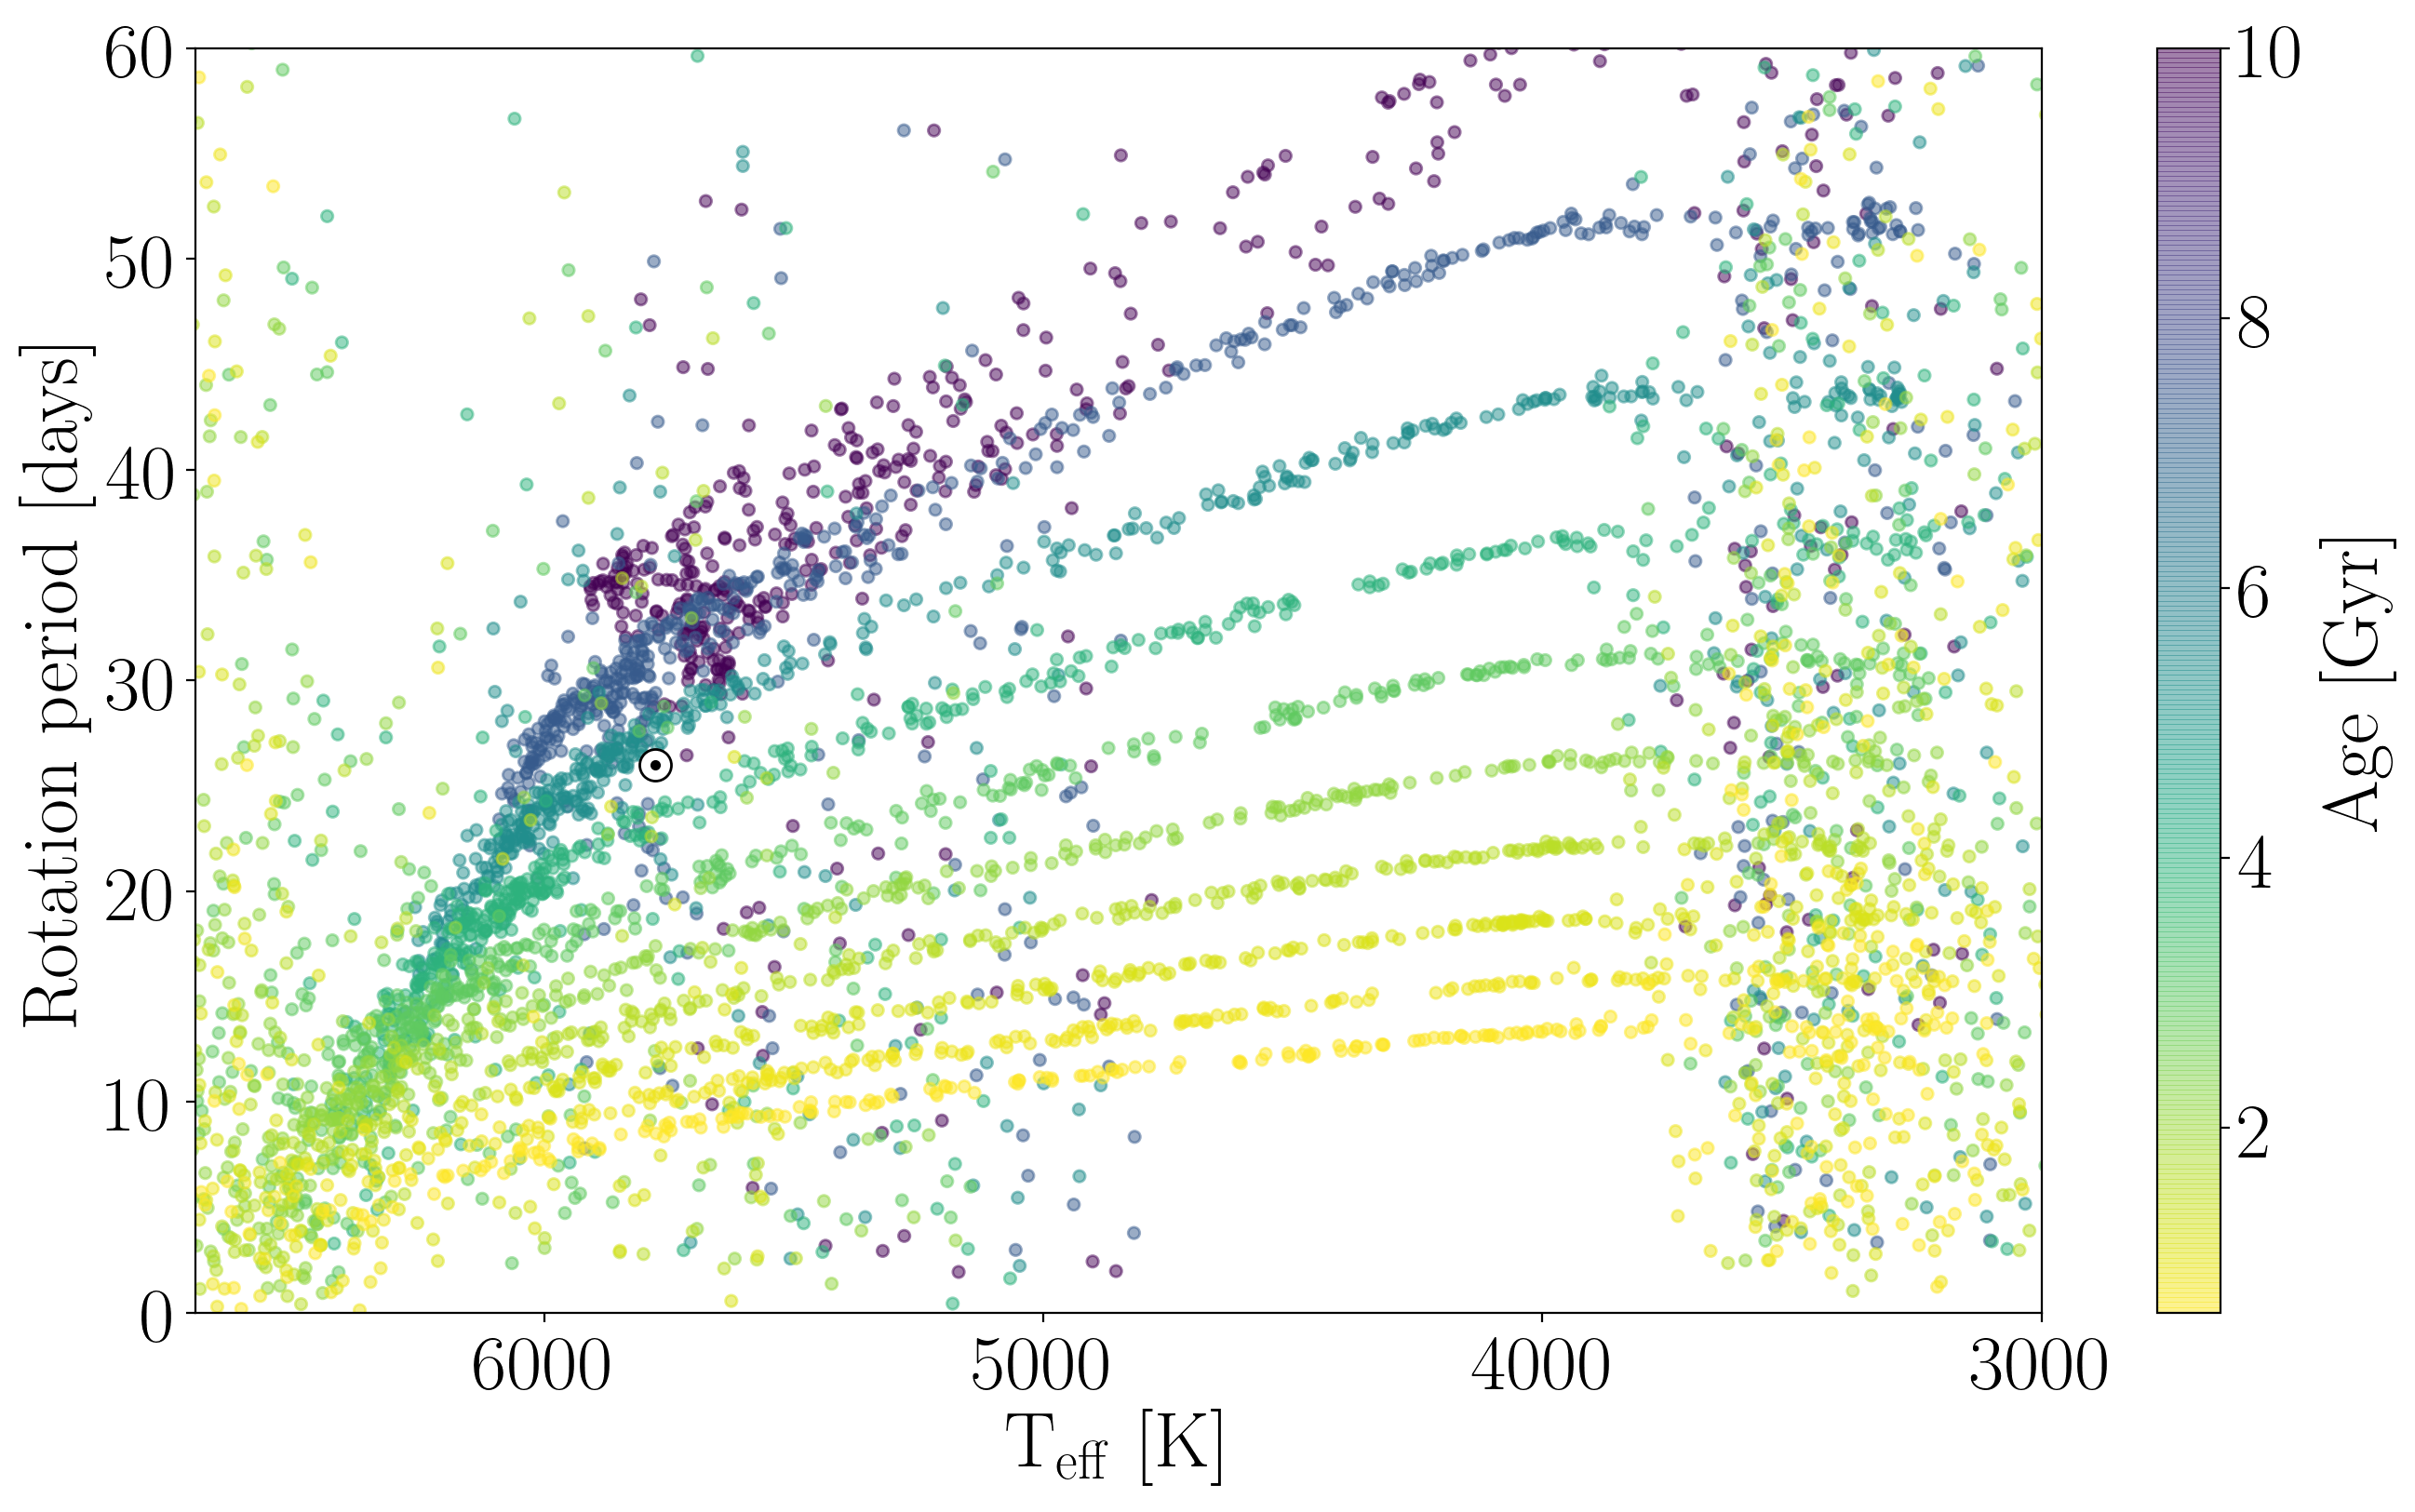

In [70]:
plt.figure(figsize=(16, 9), dpi=200)

def gyr(log10_age):
    return (10**log10_age)*1e-9

for i in np.linspace(10, 8.8, 10):
    m = (gyr(i) < gyr(large_df.age)) * (gyr(large_df.age) < gyr(i) + .01)
    plt.scatter(large_df.teff[m], 10**np.log10(large_df.prot[m]), c=gyr(large_df.age)[m],
                vmin=gyr(8.8), vmax=10, s=20, alpha=.5, cmap="viridis_r", rasterized=True)
plt.colorbar(label="$\mathrm{Age~[Gyr]}$")

# Sun
plt.scatter(5778, 26, facecolors='w', edgecolors="k", s=150, zorder=3, rasterized=True)
plt.plot(5778, 26, "k.", zorder=3, rasterized=True)

# plt.plot(5779, 26, "*", color="C1", markeredgecolor="k", ms=20)
plt.xlim(6700, 3000)
plt.ylim(0, 60)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.savefig("../gyro_model.pdf")
plt.savefig("gyro_model")

And plot a model of the variance.

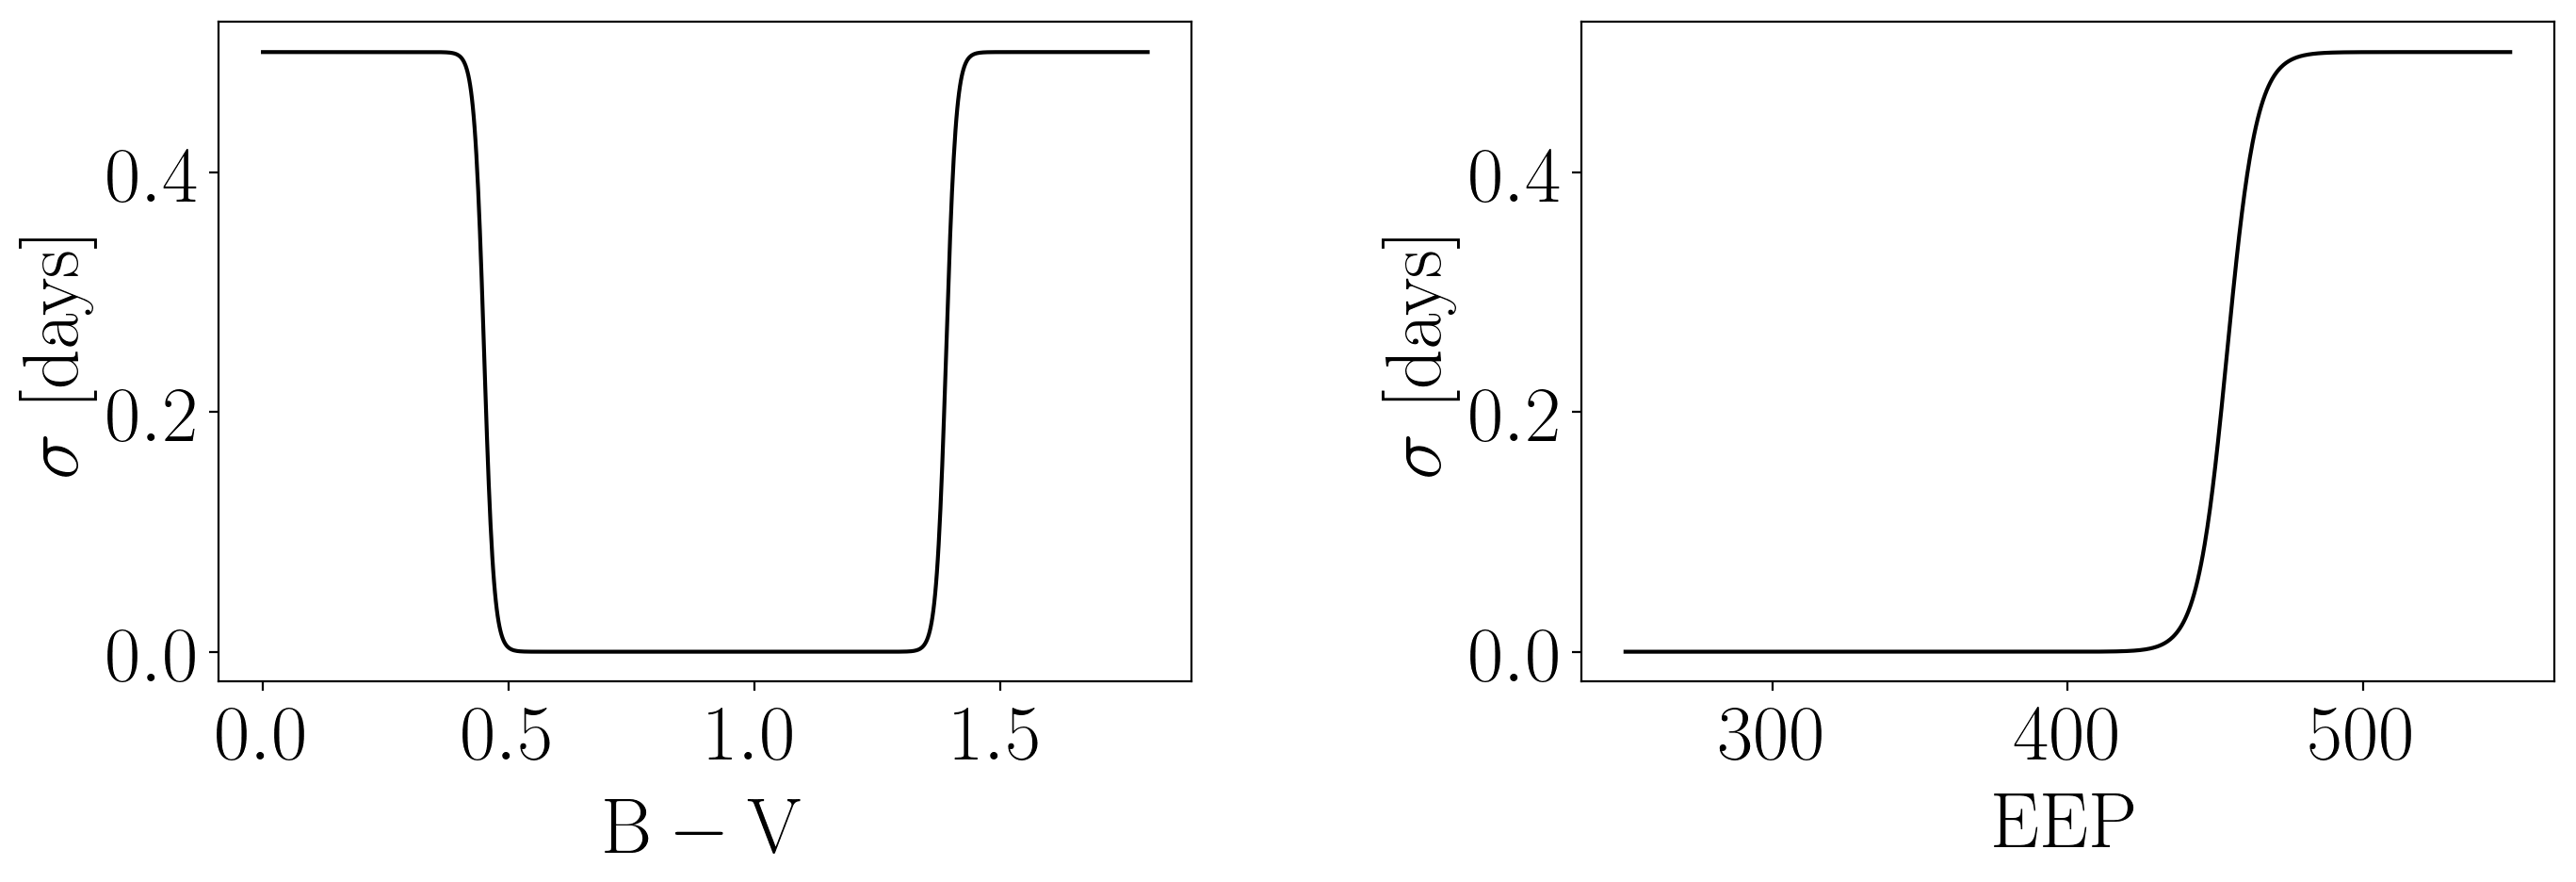

In [88]:
from stardate.lhf import sigma

nplot = 1000
bvs = np.linspace(0, 1.8, nplot)
eeps = np.linspace(250, 550, nplot)

plt.figure(figsize=(16, 5), dpi=200)
plt.subplot(1, 2, 1)
plt.plot(bvs, sigma(bvs, 355), "k", rasterized=True)
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{\sigma~[days]}$")

plt.subplot(1, 2, 2)
plt.plot(eeps, sigma(.65, eeps), "k", rasterized=True)
plt.xlabel("$\mathrm{EEP}$")
plt.ylabel("$\mathrm{\sigma~[days]}$")
plt.subplots_adjust(bottom=.18, wspace=.4)
plt.savefig("../variance.pdf")
plt.savefig("variance")